# Applied Machine Learning CS5785 Homework 1
## Programming Exercise 2 - Predicting House Prices


Group: Ting-Wei Chiang (tc695), Jeremy Shaffer (jms995)

Kaggle competition: https://www.kaggle.com/c/house-prices-advanced-regression-techniques

In [1]:
# Import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 6]

In [2]:
# Load dataset
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

### Data Exploration

From our first glance of data, we observed that: 
1. There are both numeric and categorical features.
2. There are some missing values (NaNs) that need to be taken care of.
3. Column `Id` should be excluded from features.
4. Column `SalePrice` only exists in training data, and is approximately a 6-figure number.
5. The dimension of training data is 81 while that of testing data is 80 because training data includes target variable `SalePrice`.

In [3]:
print ("Train data shape:", train.shape)
print ("Test data shape:", test.shape)

Train data shape: (1460, 81)
Test data shape: (1459, 80)


In [4]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
# test.head()

### Data preprocessing

For data preprocessing and feature engineering, we did the followings:
1. Scaling Training Target: Log transform the skewed target variable by taking $log(SalePrice)$
2. Drop column `Id`
3. For Numeric Features: 
    1. Missing data imputation
    2. Log transform the skewed features by taking $log(feature + 1)$
4. For Categorical Features: One-hot encoding

#### 1. Scaling Training Target

We used `plt.hist()` to plot a histogram of `SalePrice`. From the first graph, we can see that the original distribution of `SalePrice` in training data is positively-skewed (right-skewed). 
As we are performing regression, we applied log transformation on the skewed variable to improve the linearity of the data. After log transformation, the histogram looks more like normal distribution, and the skewness value is closer to 0. Lastly, we stored the log-transformed training target in a new variable `y_train_all`. 

In [6]:
# train.SalePrice.describe()

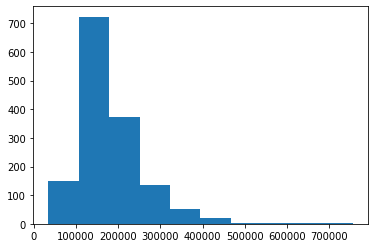

Skewness for Saleprice = 1.8828757597682129


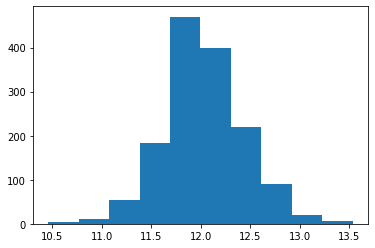

Skewness for log(Saleprice) = 0.12133506220520406


In [7]:
# Plot histograms

# original distribution
plt.hist(train.SalePrice)
plt.show()
print ("Skewness for Saleprice =", train.SalePrice.skew())
# distribution after log transformation
plt.hist(np.log(train.SalePrice))    
plt.show()
print ("Skewness for log(Saleprice) =", np.log(train.SalePrice).skew())

In [8]:
# Log transform training target
y_train_all = np.log(train.SalePrice)

#### 2. Drop column `Id` 

Since the same process of feature engineering needs to be performed on both training and testing data, we combined them first to variable `X`, and later separated them back to `X_train_all` and `X_test` depending on whether they have values for column `SalePrice` or not. 

We dropped the column `Id` because it does not convey any meaning to the housing price and should be excluded from the set of features.

In [9]:
X = pd.concat([train, test], ignore_index=True, sort=False)
X_target = X.SalePrice
X = X.drop(columns = ['Id', 'SalePrice'])

#### 3. Feature Engineering for Numeric Features

In [10]:
# Filter out numerical features
numeric_features = X.select_dtypes(include=[np.number])

In [11]:
# Compute pearson correlation among all numerical features
corr = train.select_dtypes(include=[np.number]).corr()

# Output the highest 5 positively and negatively-correlated features of target variable
# print (corr['SalePrice'].sort_values(ascending=False)[1:6])
# print (corr['SalePrice'].sort_values(ascending=True)[:5])

#### 3A. Missing Data Imputation

Most missing values come from `LotFrontage`(486 rows) and `GarageYrBlt`(159 rows). 

The definition of feature `LotFrontage` is " Linear feet of street connected to property." We hypothesized that the missing values indicate that there are no street connected to the property. Thus, we fill in 0 values.

The definition of feature `GarageYrBlt` is "Year garage was built." We hypothesized that the missing values mean that there is no garage in the property. However, since this feature is highly correlated to another feature `YearBuilt` (r = 0.825667), we chose to fill in the corresponding values of `YearBuilt` to the missing values of `GarageYrBlt`.

As for the rest of the features with missing values, we simply filled in the *median* of the feature because this method is easy and fast, and it works well with small numerical datasets.

In [12]:
# List what numeric variables have missing values
train_null_count = numeric_features.isnull().sum()
train_null_count[train_null_count > 0].sort_values(ascending=False)

LotFrontage     486
GarageYrBlt     159
MasVnrArea       23
BsmtHalfBath      2
BsmtFullBath      2
GarageArea        1
GarageCars        1
TotalBsmtSF       1
BsmtUnfSF         1
BsmtFinSF2        1
BsmtFinSF1        1
dtype: int64

In [13]:
# LotFrontage: Linear feet of street connected to property

# X.LotFrontage.describe()
X.LotFrontage = X.LotFrontage.fillna(0)

In [14]:
# GarageYrBlt: Year garage was built

# X.GarageYrBlt.describe()
print (corr['GarageYrBlt'].sort_values(ascending=False)[1:6])
# print (corr['GarageYrBlt'].sort_values(ascending=True)[:5])

X.GarageYrBlt = X.GarageYrBlt.fillna(X.YearBuilt).astype('int64')

YearBuilt       0.825667
YearRemodAdd    0.642277
GarageCars      0.588920
GarageArea      0.564567
OverallQual     0.547766
Name: GarageYrBlt, dtype: float64


In [15]:
# The rest of the features: fill in median of the feature
X = X.fillna(X.median())

#### 3B. Scaling numerical features

Log transform skewed numeric features by taking $log(feature + 1)$. This is because linear regression models work better with feature distribution close to Gaussian Distribution. We defined the skewed features as features with skewness less than -1 or greater than 1, following a general rule of thumb cited [here](https://help.gooddata.com/doc/en/reporting-and-dashboards/maql-analytical-query-language/maql-expression-reference/aggregation-functions/statistical-functions/predictive-statistical-use-cases/normality-testing-skewness-and-kurtosis#:~:text=As%20a%20general%20rule%20of,the%20distribution%20is%20approximately%20symmetric.).



In [16]:
skewed_features = X[numeric_features.columns].apply(lambda x: x.skew()) # compute skewness
skewed_features = skewed_features[(skewed_features > 1) | (skewed_features < -1)]
skewed_features = skewed_features.index
print("Skewed features: ", skewed_features.values)

X[skewed_features] = np.log1p(X[skewed_features])

Skewed features:  ['MSSubClass' 'LotArea' 'MasVnrArea' 'BsmtFinSF1' 'BsmtFinSF2'
 'TotalBsmtSF' '1stFlrSF' 'LowQualFinSF' 'GrLivArea' 'BsmtHalfBath'
 'KitchenAbvGr' 'WoodDeckSF' 'OpenPorchSF' 'EnclosedPorch' '3SsnPorch'
 'ScreenPorch' 'PoolArea' 'MiscVal']


#### 4. Feature Engineering for Categorical Features

For categorical features, we simply perform one-hot encoding using `pd.get_dummies()`, which converts categorical variable into dummy/indicator variables.

Finally, we get 288 features in total.

In [17]:
# List what categorical variables have missing values
train_null_count = X.isnull().sum()    # can also use df.isna()
train_null_count[train_null_count > 0].sort_values(ascending=False)

PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
FireplaceQu     1420
GarageCond       159
GarageQual       159
GarageFinish     159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MSZoning           4
Functional         2
Utilities          2
Exterior1st        1
SaleType           1
Exterior2nd        1
KitchenQual        1
Electrical         1
dtype: int64

In [18]:
# One hot encoding
X = pd.get_dummies(X)

In [19]:
X = pd.concat([X, X_target], axis=1)
X_train_all = X.loc[X['SalePrice'].notna()]
X_test = X.loc[X['SalePrice'].isna()]

# Drop columns
X_train_all = X_train_all.drop(columns = ['SalePrice'])
X_test = X_test.drop(columns = ['SalePrice'])

In [20]:
print("X_train_all shape: ", X_train_all.shape)
print("X_test shape: ",X_test.shape)

X_train_all shape:  (1460, 288)
X_test shape:  (1459, 288)


### Model

In [21]:
# import libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error

In [22]:
# Split training set (X_train) and hold out set (X_val) from all training data (X_train_all)
# test size is set to 15%
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=.15, random_state=42)

#### 1. Least squares: Linear Regression

In [23]:
lr = LinearRegression()
linear_model = lr.fit(X_train, y_train)

print ("R square for Linear Regression =", linear_model.score(X_val, y_val))
print ('RMSE for Linear Regression =', mean_squared_error(y_val, linear_model.predict(X_val), squared=False))

R square for Linear Regression = 0.9067478893453533
RMSE for Linear Regression = 0.1333051171930655


In [24]:
# train model using all training data
linear_model = LinearRegression().fit(X_train_all, y_train_all)

#### 2. Regularized Least Squares - Lasso Regression (L1 Regularization)

In [25]:
# Generate a list of alpha values
alphas = 10**np.arange(-3.8, 0, 0.1)

In [26]:
# Choose alpha by min RMSE on our validation set X_val

model_list = []
rsquare_list = []
rmse_list = []
for alpha in alphas:
    model = Lasso(alpha=alpha)
    model = model.fit(X_train, y_train)
    model_list.append(model)
    pred = model.predict(X_val)
    rsquare_list.append(model.score(X_val, y_val))
    rmse_list.append(mean_squared_error(y_val, pred, squared=False))
print("R square for Lasso Regression =", rsquare_list[rmse_list.index(min(rmse_list))])
print("RMSE for Lasso Regression =", min(rmse_list))
print("when alpha =", alphas[rmse_list.index(min(rmse_list))])

lasso_model = model_list[rmse_list.index(min(rmse_list))]

R square for Lasso Regression = 0.9301552448992806
RMSE for Lasso Regression = 0.11536774005776772
when alpha = 0.00015848931924611142


<function matplotlib.pyplot.show(*args, **kw)>

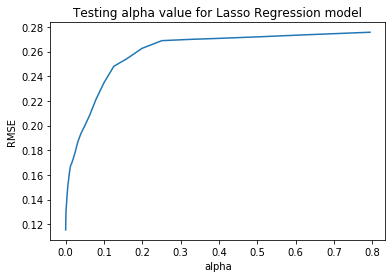

In [27]:
# Plot RMSE of different alphas

plt.plot(alphas, rmse_list)
plt.title("Testing alpha value for Lasso Regression model")
plt.xlabel("alpha")
plt.ylabel("RMSE")
plt.show

In [28]:
# Choose alpha by cross validation (cv=5) on all training set

lasso_model_cv = LassoCV(alphas = alphas, cv=5).fit(X_train_all, y_train_all)
print ("R square for Lasso Regression =", lasso_model_cv.score(X_val, y_val))
print ("RMSE for Lasso Regression =", mean_squared_error(y_val, lasso_model_cv.predict(X_val), squared=False))
print ("when alpha =", lasso_model_cv.alpha_)

R square for Lasso Regression = 0.9480071434877752
RMSE for Lasso Regression = 0.09953809506505314
when alpha = 0.000501187233627273


Lasso picked 107 variables and eliminated the other 181 variables


Text(0.5, 1.0, 'Coefficients in the Lasso Model')

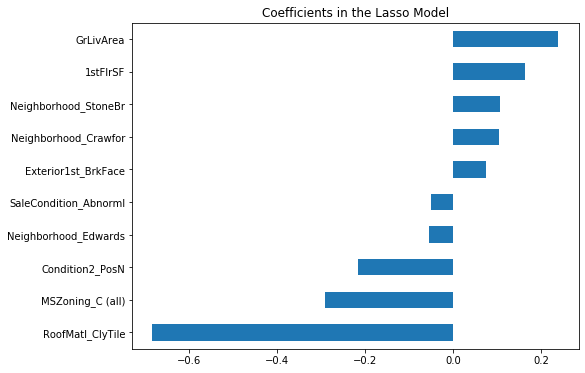

In [29]:
# Plot coefficients in the Lasso model

coef = pd.Series(lasso_model_cv.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

imp_coef = pd.concat([coef.sort_values().head(5),
                     coef.sort_values().tail(5)])
plt.rcParams['figure.figsize'] = (8.0, 6.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

#### 3. Regularized Least Squares: Lasso Regression (L2 Regularization)

In [30]:
# Generate a list of alpha values
alphas = 10**np.arange(-2, 1.8, 0.1)

In [31]:
# Choose alpha by min RMSE on our validation set X_val

model_list = []
rsquare_list = []
rmse_list = []
for alpha in alphas:
    model = Ridge(alpha=alpha)
    model = model.fit(X_train, y_train)
    model_list.append(model)
    pred = model.predict(X_val)
    rsquare_list.append(model.score(X_val, y_val))
    rmse_list.append(mean_squared_error(y_val, pred, squared=False))
print("R square for Ridge Regression =", rsquare_list[rmse_list.index(min(rmse_list))])
print("RMSE for Ridge Regression =", min(rmse_list))
print("when alpha =", alphas[rmse_list.index(min(rmse_list))])

ridge_model = model_list[rmse_list.index(min(rmse_list))]

R square for Ridge Regression = 0.925594926955858
RMSE for Ridge Regression = 0.11907449807431947
when alpha = 0.1995262314968885


<function matplotlib.pyplot.show(*args, **kw)>

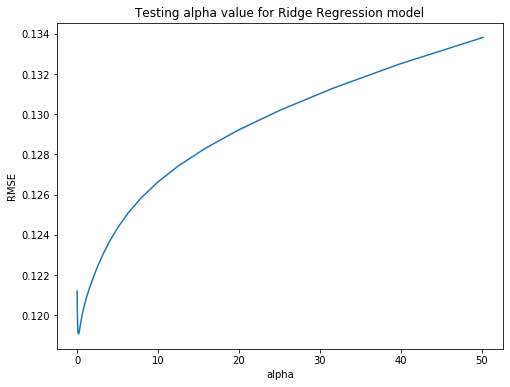

In [32]:
# Plot RMSE of different alphas

plt.plot(alphas, rmse_list)
plt.title("Testing alpha value for Ridge Regression model")
plt.xlabel("alpha")
plt.ylabel("RMSE")
plt.show

In [33]:
# Choose alpha by cross validation (cv=5) on all training set

ridge_model_cv = RidgeCV(alphas = alphas, cv=5).fit(X_train_all, y_train_all)
print ("R square for Ridge Regression =", ridge_model_cv.score(X_val, y_val))
print ("RMSE for Ridge Regression =", mean_squared_error(y_val, ridge_model_cv.predict(X_val), squared=False))
print ("when alpha =", ridge_model_cv.alpha_)

R square for Ridge Regression = 0.9442285350494903
RMSE for Ridge Regression = 0.10309165506693088
when alpha = 12.589254117941753


Text(0.5, 1.0, 'Coefficients in the Ridge Model')

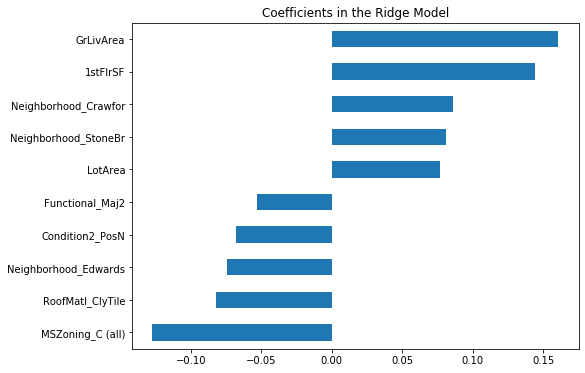

In [34]:
# Plot coefficients in the Ridge model

coef = pd.Series(ridge_model_cv.coef_, index = X_train.columns)
imp_coef = pd.concat([coef.sort_values().head(5),
                     coef.sort_values().tail(5)])
plt.rcParams['figure.figsize'] = (8.0, 6.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")

### Submission to Kaggle

In [35]:
pred_linear = np.exp(linear_model.predict(X_test))
pred_lasso = np.exp(lasso_model.predict(X_test))
pred_ridge = np.exp(ridge_model.predict(X_test))
pred_lassocv = np.exp(lasso_model_cv.predict(X_test))
pred_ridgecv = np.exp(ridge_model_cv.predict(X_test))

In [36]:
res = pd.DataFrame()
res['Id'] = test.Id
res['SalePrice'] = pred_linear
res.to_csv('./res/linear.csv', index=False)

In [37]:
res = pd.DataFrame()
res['Id'] = test.Id
res['SalePrice'] = pred_lasso
res.to_csv('./res/lasso.csv', index=False)

In [38]:
res = pd.DataFrame()
res['Id'] = test.Id
res['SalePrice'] = pred_ridge
res.to_csv('./res/ridge.csv', index=False)

In [39]:
res = pd.DataFrame()
res['Id'] = test.Id
res['SalePrice'] = pred_lassocv
res.to_csv('./res/lassocv.csv', index=False)

In [40]:
res = pd.DataFrame()
res['Id'] = test.Id
res['SalePrice'] = pred_ridgecv
res.to_csv('./res/ridgecv.csv', index=False)